# MPI 5.0 Application Binary Interface (ABI) through Wi4MPI


The Wi4MPI layer allows one to compile code with one MPI implementation (such as OpenMPI) and then use another MPI implementation (such as MPICH) at runtime. This is called a Application Binary Interface that is a part of the MPI standard since the 5.0 specification. At the time of these benchmarks, the MPI implementations do not obey the 5.0 specification yet, and thus a translation layer is required. This translation layer is Wi4MPI in these benchmarks.

The software stack used here is defined by the complementary Dockerfile, which utilizes Spack to install OpenMPI, MPICH and Wi4MPI in an Ubuntu image. 

We run 2 benchmarks:
- Bi-directional bandwidth, a basic point-to-point data transfer
- All-reduce, a more complicated collective which utilize many (the number changing over time) parallel processes

There are 3 different methods we execute the mpi tests:
- Native execution with `mpirun -np x ./benchmark`
- Wi4MPI Preload mode execution such as `mpirun -F openmpi -T mpich -np x ./benchmark` which uses Wi4MPI to translate (F)rom a OpenMPI compiled binary (T) the mpich runtime binary
- Wi4MPI Interface mode execution such as `mpirun -T mpich -np x ./benchmark` which uses binaries compiled with the Wi4MPI ABI (T)o MPICH

The variable mpi in this notebook refers to the runtime MPI implementation and **not** the compiled 

This Jupyter Notebook is run using `uv` with the pyproject.toml and uv.lock environment using `uv run jupyter notebook` in this folder.

In [232]:
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [278]:
# Test setup specification
osu_results_folder = Path("osu-benchmarks/results/")
tests = {
    "allred": {"processes": 4, "metric": "Avg Latency(us)", "name": "OSU MPI Allreduce Latency Test"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)", "name": "OSU MPI Bi-Directional Bandwidth Test"},
}

matrix = {"Benchmark": ["allred", "bw"],
          "MPI": ["mpich", "ompi"],
          "Method": ["native", "interface", "preload"]}

In [234]:
# Helper functions
def extract_params_from_file(*, fd: Path, delimiter: str = '-') -> str:
    """
    Parses and extracts parameters from the file name
    
    Args:
        fd (Path): delimiter-separated string ending in .txt
        delimiter (str): default is hyphen '-'

    Returns:
        param_dict (dict): Extracted parameter dictionary
    """
    file_name = fd.name.split('.txt')[0]
    params = file_name.split(delimiter)
    param_dict = {"MPI": params[0],
                  "Method": params[1],
                  "Benchmark": params[2]}
    return param_dict

In [267]:
def filter_df(df, **kwargs):
    """
    Filter a Dataframe based on a dictionary with Column names as keys

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    kwargs : dict
        Arbitrary keyword arguments are parsed as dictionary {'Column': 'value'} 
        
    Returns
    -------
    df: pd.DataFrame
        The filtered results showing only columns with the chosen value
    """
    for name, value in kwargs.items():
        df = df[df[name] == value]
    return df

In [268]:
def read_osu_results_file(*, file_path: Path) -> pd.DataFrame:
    """
    Load the actual test/benchmark results from results file.

    Returns
    -------
    df_osu_results : pd.DataFrame
        A long-form pandas dataframe containing the results.

    Notes
    -----
    Assumes that the results file is similar to:

    # OMB Python MPI Allgather Test
    # Size (B)      Latency (us)
    1                       6.81
    2                       6.79
    4                       6.82
    ...

    I.e., it is a fixed with text file, with:
    - two header rows prefixed by "# ": 1. The name of the test, 2. The column names and units
    - a 16 character first column containing integers
    - a 12 character second column containing decimal numbers
    """
    params = extract_params_from_file(fd=file_path)
    
    with file_path.open(mode="r") as f:
        header = 1
        if params['Method'] != "native":
            f.readline().strip()
            header += 1
        test_name = f.readline().removeprefix("# ").strip()
        column = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", column)
    osu_colspecs = [(0, 16), (16, 29)]
    
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=header,
        names=column_names,
        dtype=osu_dtypes,
    )
    
    df_osu_results["MPI"] = params['MPI']
    df_osu_results["Method"] = params['Method']
    df_osu_results["Benchmark"] = params['Benchmark']
    return df_osu_results
    

In [269]:
def show_osu_pivot_table(
    *, df: pd.DataFrame, metric: str
) -> pd.DataFrame:
    """
    Create a pivot table for the OSU results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    metric : str
        The metric used in the OSU benchmark.
    containers : list of str
        The containers in the OSU results dataframe.

    Returns
    -------
    df_pivot: pd.DataFrame
        The pivot table.
    """

    df_pivot = (
        df.pivot(index="Size", columns=["Benchmark", "MPI", "Method"], values=[metric])
        .reindex(columns=matrix["MPI"], level="MPI")
        .reindex(columns=matrix["Method"], level="Method")
    )
    return df_pivot

In [270]:
def barplot_osu_results(
    *, df: pd.DataFrame, benchmark: str, mpi: str,
) -> mpl.figure.Figure:
    """
    Create a barplot of OSU results dataframe.

    Create a plot of `metric` vs message size with `containers` overlaid and
    single/multi node facetted.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a barplot for.
    benchmark : str
        A string signifying either single-node run or multi-node run, "single" or "multi"

    Returns
    -------
    mpl.figure.Figure
        The barplot figure handle.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    palette_colors = sns.color_palette('tab10')
    palette_dict = {method: color for method, color in zip(matrix["Method"], palette_colors)}
    sns.barplot(
        df,
        x="Size",
        y=tests[benchmark]["metric"],
        hue="Method",
        palette=palette_dict,
        legend="brief",
        ax=ax,
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_yscale("log")
    ax.legend(title=mpi)
    fig.suptitle(f"Local {tests[benchmark]["name"]} results - {tests[benchmark]["processes"]} processes")
    fig.tight_layout()

    return fig

In [271]:
# Load the data into a DataFrame with all results concatenated
osu_df = pd.concat(
    [
        read_osu_results_file(file_path=file_path)
        for file_path in osu_results_folder.glob("*-*-[ab]*.txt")
    ]
)
osu_df= osu_df.sort_values(by=['Method'])


## Bi-directional bandwidth test results

In [272]:
benchmark = "bw"
print(f"Local {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark),
    metric=tests[benchmark]["metric"],
)

Local OSU MPI Bi-Directional Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                                                  
Benchmark               bw                                                  
MPI                  mpich                          ompi                    
Method              native interface   preload    native interface   preload
Size                                                                        
1                     9.95      2.54      3.09     18.84      9.39      9.47
2                    20.51      5.38      7.29     39.56     19.03     18.98
4                    39.88     14.71     14.52     78.51     38.16     38.05
8                    81.35     35.67     29.05    158.10     74.96     76.22
16                  158.07     72.04     57.53    269.49    140.26    138.17
32                  320.54    126.76    115.48    548.69    283.15    280.54
64                  635.26    255.13    229.62    702.73    447.79    454.52
128                1215.43    518.83    446.30   1099.63    756.35    763.54
256                2346.03   1559.80    863.67   2039.52   1422.01   1445.43
512                4147.72   2842.03   1592.12   4117.44   2990.70   3075.69
1024               7145.65   5045.01   2885.34   7234.31   5508.88   5580.72
2048              11342.04   8565.89   5016.77  11291.71   8805.52   8969.41
4096              15501.90  12753.98   7650.66  11179.87   9878.40  10066.11
8192              21201.51  18582.57  11056.32  14991.34  13603.65  13738.00
16384             18327.79  17139.30  13379.34  20753.50  19075.02  19286.10
32768             20841.99  20293.04  19361.96  23774.43  22659.83  22511.00
65536             22533.56  22209.31  21747.19  24466.90  24664.99  24942.67
131072            23660.40  23233.37  22756.16  23051.35  22392.61  22553.04
262144            22208.14  22221.76  21753.21  23279.70  22094.45  22876.26
524288            17459.42  18735.12  18583.67  22331.95  22493.89  22423.79
1048576           17944.49  19105.55  19010.36  21611.64  20905.52  21446.97
2097152           17111.87  17940.51  19130.96  20840.65  20783.27  20847.80
4194304           14935.73  15436.01  14961.55  20528.28  20175.65  20431.07

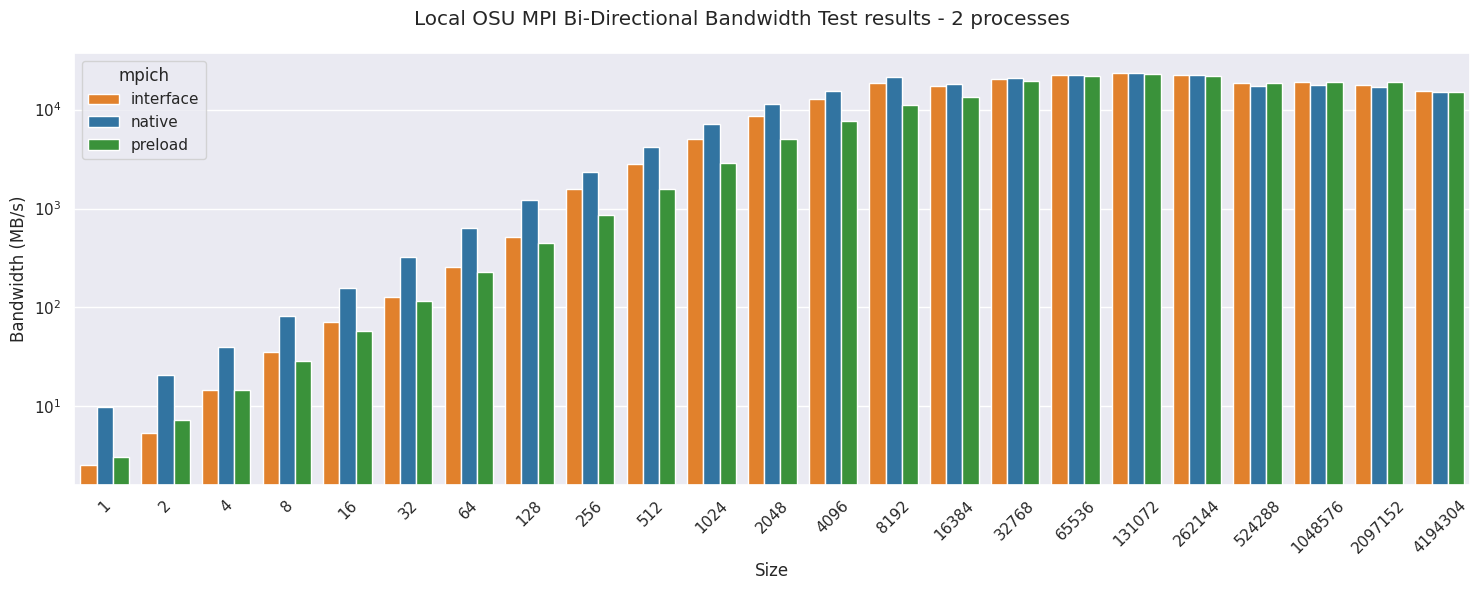

In [273]:
benchmark = "bw"; mpi="mpich"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, MPI=mpi),
    benchmark=benchmark, mpi=mpi
)

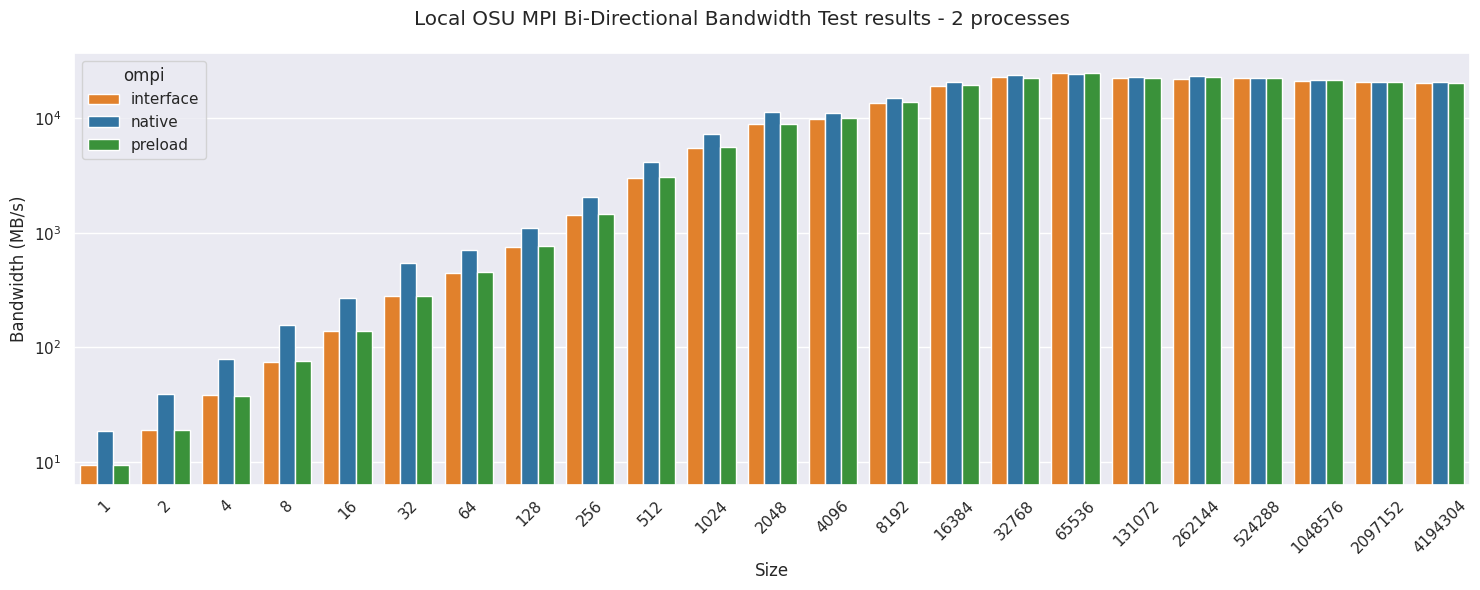

In [274]:
benchmark = "bw"; mpi="ompi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, MPI=mpi),
    benchmark=benchmark, mpi=mpi
)

## All reduce results

In [275]:
benchmark = "allred"
print(f"Local {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark),
    metric=tests[benchmark]["metric"],
)

Local OSU MPI Allreduce Latency Test results - 4 processes
(lower is better)


Avg Latency(us)                                            
Benchmark          allred                                            
MPI                 mpich                      ompi                  
Method             native interface preload  native interface preload
Size                                                                 
4                    1.89      1.12    1.00    0.72      0.74    0.73
8                    1.52      0.79    1.04    0.66      0.73    0.72
16                   1.96      0.71    1.05    0.67      0.80    0.78
32                   1.58      0.70    1.02    0.66      0.83    0.78
64                   1.51      0.68    0.67    0.67      0.81    0.78
128                  1.56      0.74    0.73    1.21      0.86    0.85
256                  1.02      0.96    0.89    0.83      0.92    0.91
512                  1.18      1.20    1.08    1.35      1.66    1.52
1024                 1.37      1.81    1.58    1.64      1.96    1.81
2048                 1.84      2.49    2.25    2.03      2.48    2.27
4096                 3.17      4.26    4.06    4.23      5.34    5.25
8192                 5.71      7.51    7.01    6.34      7.88    7.42
16384               11.77     15.28   14.00   10.76     12.36   12.16
32768               23.52     29.60   23.43   18.01     21.49   19.23
65536               46.95     47.57   46.74   30.88     33.13   35.75
131072              97.45    101.41   92.29   57.11     60.83   61.95
262144             197.38    190.77  184.91  111.79    115.71  117.86
524288             387.34    379.10  363.65  242.28    254.92  257.34
1048576            700.28    766.03  700.97  528.53    595.99  575.81

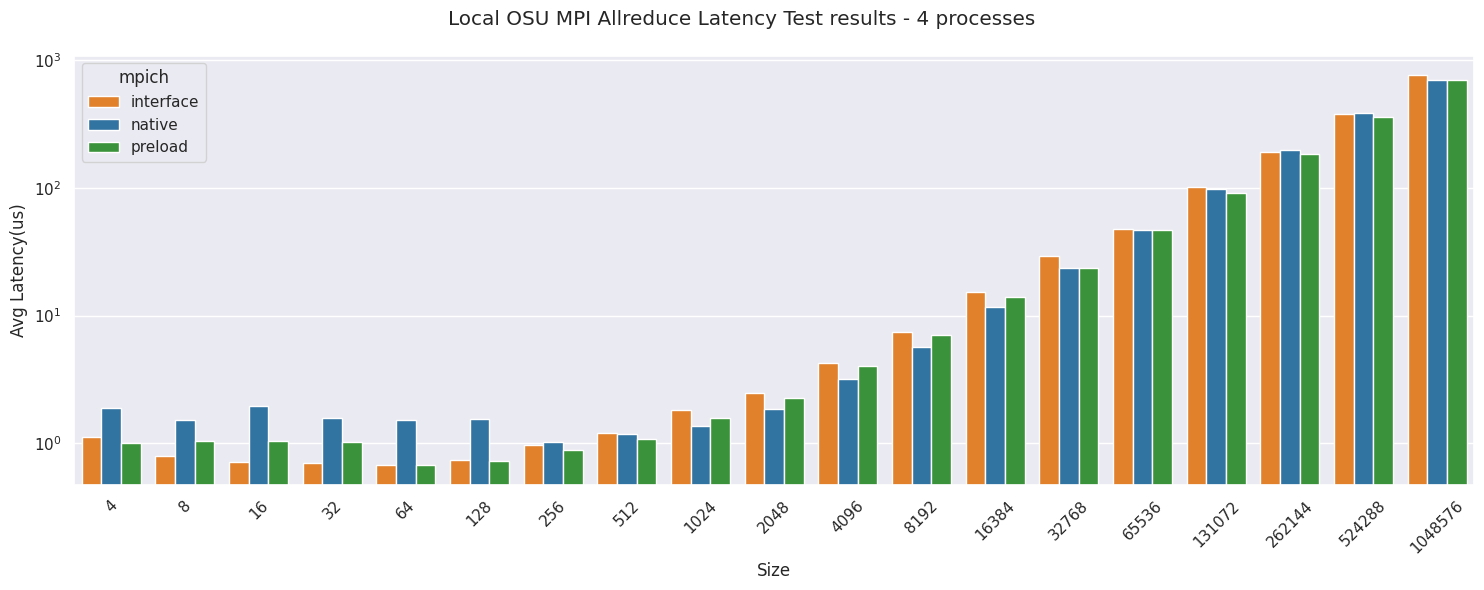

In [276]:
benchmark = "allred"; mpi="mpich"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, MPI=mpi),
    benchmark=benchmark, mpi=mpi
)

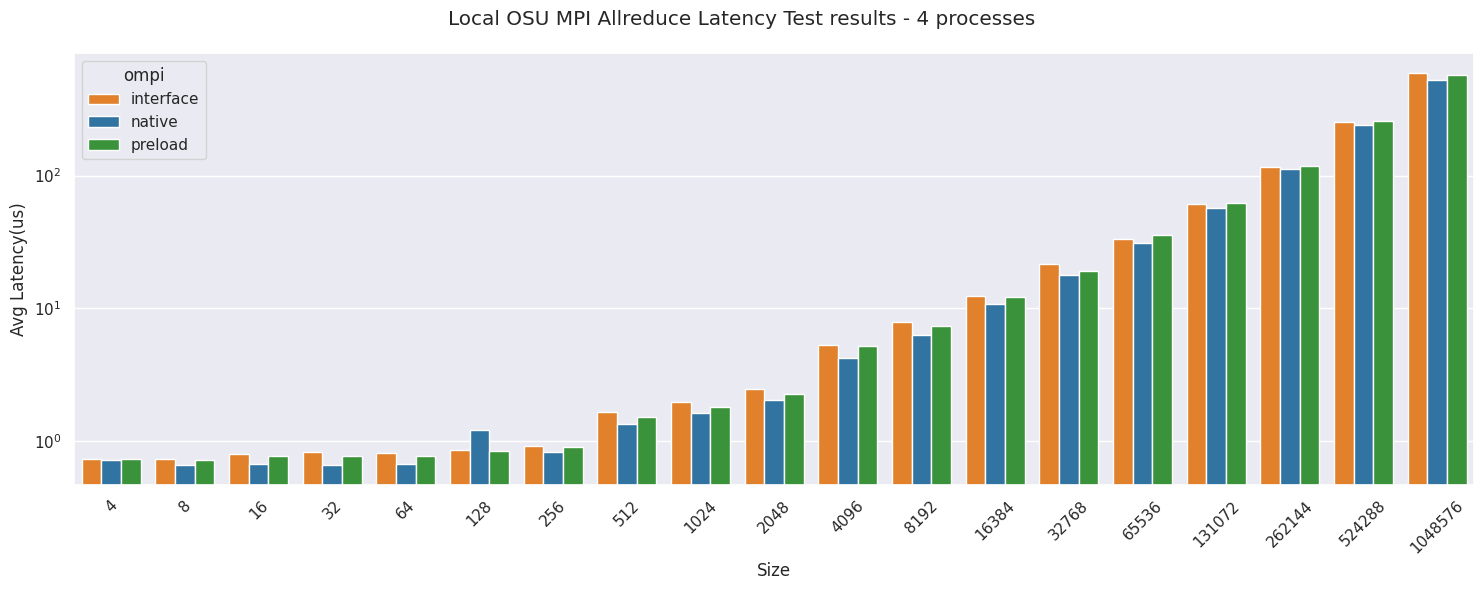

In [277]:
benchmark = "allred"; mpi="ompi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, MPI=mpi),
    benchmark=benchmark, mpi=mpi
)